# PNC Mixed Effects

Only use subjects age_at_cnb > 16

- Mixed effects: scan task, sex, race, error (+ maybe individual)
- Try predicting scan task, sex, race after training

In [1]:
import pickle
import numpy as np

demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/'

demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

rest = []
nback = []
emoid = []

for sub in demo['age_at_cnb']:
    try:
        a = demo['age_at_cnb'][sub]
        if a <= 16:
            continue
        r = demo['Race'][sub]
        s = demo['Sex'][sub]
        if r not in ['EA', 'AA']:
            continue
    except:
        continue
    r = int(r == 'AA')
    s = int(s == 'M')
    try:
        pr = np.load(f'{demodir}/fc/{sub}_task-rest_fc.npy')
        rest.append((pr, r, s))
    except:
        pass
    try:
        pn = np.load(f'{demodir}/fc/{sub}_task-nback_fc.npy')
        nback.append((pn, r, s))
    except:
        pass
    try:
        pe = np.load(f'{demodir}/fc/{sub}_task-emoid_fc.npy')
        emoid.append((pe, r, s))
    except:
        pass

print(len(rest), len(nback), len(emoid))

419 432 435


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def rmse_torch(y, yhat):
    return torch.mean((y-yhat)**2)

class MixedEffects(nn.Module):
    def __init__(self):
        super(MixedEffects, self).__init__()
        self.site = 0
        self.task = nn.Parameter(torch.randn(3,10,10,264).float().cuda())
        self.sex = nn.Parameter(torch.randn(2,10,10,264).float().cuda())
        self.race = nn.Parameter(torch.randn(2,10,10,264).float().cuda())

    def softmax(self, subs):
        task = F.softmax(subs['task'], dim=-1)
        sex = F.softmax(subs['sex'], dim=-1)
        race = F.softmax(subs['race'], dim=-1)
        t = F.softmax(subs['task_ind'], dim=-1)
        s = F.softmax(subs['sex_ind'], dim=-1)
        r = F.softmax(subs['race_ind'], dim=-1)
        return task, sex, race, t, s, r

    def vecpars(self):
        a,b = torch.triu_indices(264,264,offset=1)
        task = torch.einsum('abcd,abce->abde', self.task, self.task)
        sex = torch.einsum('abcd,abce->abde', self.sex, self.sex)
        race = torch.einsum('abcd,abce->abde', self.race, self.race)
        task = torch.clamp(task, min=-1, max=1)
        sex = torch.clamp(sex, min=-1, max=1)
        race = torch.clamp(race, min=-1, max=1)
        return task[:,:,a,b], sex[:,:,a,b], race[:,:,a,b]
        
    def forward(self, subs):
        t, s, r, ti, si, ri = self.softmax(subs)
        task, sex, race = self.vecpars()
        task = torch.einsum('na,abc->nbc',t,task)
        task = torch.einsum('nb,nbc->nc',ti,task)
        sex = torch.einsum('na,abc->nbc',s,sex)
        sex = torch.einsum('nb,nbc->nc',si,sex)
        race = torch.einsum('na,abc->nbc',r,race)
        race = torch.einsum('nb,nbc->nc',ri,race)
        sum = task + sex + race
        bnloss = 0 #self.binary_loss(ti, si, ri)
        return sum, bnloss

    def binary_loss(self, task, sex, race):
        t = torch.mean(torch.log(task)*task)
        s = torch.mean(torch.log(sex)*sex)
        r = torch.mean(torch.log(race)*race)
        return -t-s-r

print('Complete')

Complete


In [20]:
N = len(rest)+len(nback)+len(emoid)
subs = dict(task=torch.zeros(N,3).float().cuda(), 
            sex=torch.zeros(N,2).float().cuda(), 
            race=torch.zeros(N,2).float().cuda(), 
            p=torch.zeros(N,34716).float().cuda(),
            task_ind=torch.randn(N,10).float().cuda().requires_grad_(),
            sex_ind=torch.randn(N,10).float().cuda().requires_grad_(),
            race_ind=torch.randn(N,10).float().cuda().requires_grad_()
           )

count = 0
site = torch.zeros(34716).float().cuda()

for i,task in enumerate([rest, nback, emoid]):
    for sub in task:
        subs['task'][count,i] = 1
        subs['sex'][count,sub[2]] = 1
        subs['race'][count,sub[1]] = 1
        p = torch.from_numpy(sub[0]).float().cuda()
        subs['p'][count] = p
        count += 1
        site += p

site = site/count

print('Complete')

Complete


In [21]:
from itertools import chain

me = MixedEffects()
optim = torch.optim.Adam(list(me.parameters()) + [subs['task_ind'], subs['sex_ind'], subs['race_ind']], lr=1e-2, weight_decay=0)

nepochs = 1500
pperiod = 50

for e in range(nepochs):
    optim.zero_grad()
    sum, bnloss = me(subs)
    loss = rmse_torch(subs['p'], sum)
    (loss+bnloss).backward()
    optim.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {float(loss)} {float(bnloss)}')

print('Complete')

0 0.38491958379745483 0.0
50 0.11464210599660873 0.0
100 0.0757732018828392 0.0
150 0.05965758487582207 0.0
200 0.049107760190963745 0.0
250 0.04186553135514259 0.0
300 0.0391145795583725 0.0
350 0.037807609885931015 0.0
400 0.03697923570871353 0.0
450 0.0363735668361187 0.0
500 0.03589370846748352 0.0
550 0.03550950065255165 0.0
600 0.0351899154484272 0.0
650 0.03491853550076485 0.0
700 0.03468956798315048 0.0
750 0.034489456564188004 0.0
800 0.0343150794506073 0.0
850 0.03416300192475319 0.0
900 0.0340256504714489 0.0
950 0.033900272101163864 0.0
1000 0.03378458321094513 0.0
1050 0.03367958962917328 0.0
1100 0.03358233720064163 0.0
1150 0.03349464014172554 0.0
1200 0.03341643884778023 0.0
1250 0.03334389626979828 0.0
1300 0.033278245478868484 0.0
1350 0.03321649506688118 0.0
1400 0.03315942361950874 0.0
1450 0.0331064835190773 0.0
1499 0.03305542841553688 0.0
Complete


In [6]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    ones = np.arange(264)
    fc[ones,ones] = 0
    return fc

print('Complete')

Complete


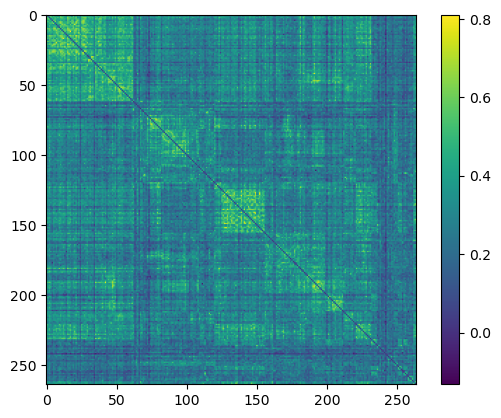

In [25]:
import matplotlib.pyplot as plt

with torch.no_grad():
    task, sex, race = me.vecpars()

plt.imshow(remap(vec2mat(sum[10].detach().cpu().numpy())))
# plt.imshow(remap(vec2mat(subs['p'][0].cpu().numpy())))
plt.colorbar()
plt.show()